In [34]:
#1.required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_circles, make_moons, make_classification
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import plotly.graph_objects as go


# For good visuals
# Set theme and context for clean visuals
sns.set_theme(style="darkgrid")
sns.set_context('notebook')

## Experiment 1: Soft-Margin SVM and Effect of the Regularization Parameter

In this experiment, we analyze the behavior of a **soft-margin Support Vector Machine** in the presence of **outliers** and overlapping class distributions.
A mostly linearly separable dataset is constructed, and additional outliers are introduced to violate the hard-margin assumption.

The experiment focuses on the effect of the **regularization parameter \(C\)**, which controls the trade-off between maximizing the margin and minimizing classification errors.
By training linear SVM models with different values of \(C\), we observe how smaller values allow larger margins at the cost of misclassification, while larger values enforce stricter separation, making the model more sensitive to outliers.

The resulting decision boundaries, margins, and support vectors are visualized to illustrate how the choice of \(C\) influences model complexity and generalization performance.


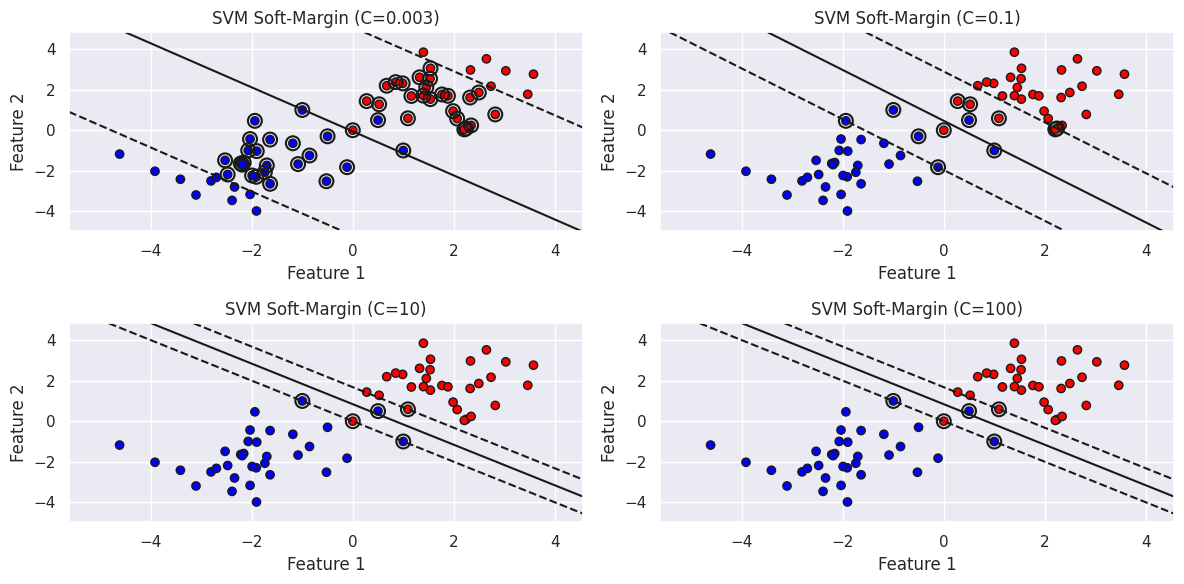

In [35]:
# -----------------------------
# Generate mostly linearly separable data with outliers
# -----------------------------
np.random.seed(42)
# two clusters
X_pos = np.random.randn(30, 2) + [2, 2]
X_neg = np.random.randn(30, 2) + [-2, -2]
X = np.vstack((X_pos, X_neg))
y = np.hstack((np.ones(30), -np.ones(30)))

# Add more outliers (some far from clusters)
outliers = np.array([[0.5, 0.5], [-0.5, -0.3], [1, -1], [-1, 1], [0, 0]])
outlier_labels = np.array([-1, -1, -1, -1, 1])
X = np.vstack((X, outliers))
y = np.hstack((y, outlier_labels))

# -----------------------------
# Plot function: decision boundary + margins
# -----------------------------
def plot_svm(ax, model, X, y, title):
    ax.clear()
    h = 0.02
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Three lines: margins and decision boundary
    ax.contour(xx, yy, Z, levels=[-1,0,1], linestyles=['--','-','--'], colors='k')

    # Plot data points
    ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolors='k')

    # Highlight support vectors
    ax.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],
               s=100, facecolors='none', edgecolors='k', linewidths=1.5)

    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

# -----------------------------
# Different C values for 2x2 plots
# -----------------------------
C_values = [0.003, 0.1, 10, 100]

fig, axes = plt.subplots(2, 2, figsize=(12,6))

for ax, C in zip(axes.flatten(), C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X, y)
    plot_svm(ax, svm, X, y, title=f"SVM Soft-Margin (C={C})")

plt.tight_layout()
plt.show()


## Experiment 2 : Non-Linear Case : Kernel-trick implimentation

In this experiment, we study a **non-linearly separable dataset** to demonstrate the effectiveness of the **kernel trick** in Support Vector Machines.
A circular dataset is used, where a linear SVM fails to find a suitable separating hyperplane in the original feature space.

The experiment proceeds in three steps. First, a **linear SVM** is applied to highlight the limitations of linear classifiers.
Second, an **explicit feature mapping** projects the data into a higher-dimensional space, showing that linear separation becomes possible after transformation.
Finally, an SVM with an **RBF kernel** is trained to implicitly perform this mapping and learn a non-linear decision boundary in the original input space.

This experiment illustrates how kernel-based methods enable SVMs to handle complex, non-linear classification problems.


#### This cell generates the circle dataset, scales the features, and defines a helper function to create a meshgrid for plotting.


In [28]:
# -----------------------------
# Generate circle dataset
# -----------------------------
X, y = make_circles(n_samples=400, factor=0.3, noise=0.1, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Create meshgrid helper
# -----------------------------
def create_meshgrid(X, h=0.02):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


### Linear SVM 2D Plot
#### This cell trains a Linear Support Vector Machine (without kernel) on the scaled circle dataset and plots the decision regions. Since the data is not linearly separable, the decision boundary will misclassify some points.


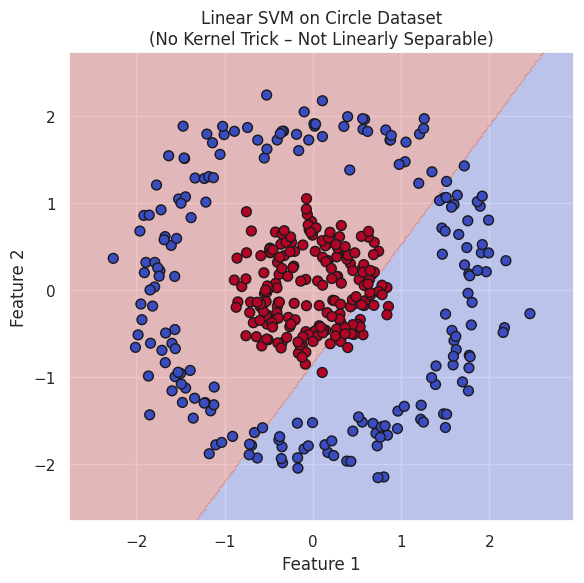

In [29]:
# -----------------------------
# Train Linear SVM
# -----------------------------
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_scaled, y)

xx, yy = create_meshgrid(X_scaled)
Z_linear = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z_linear, cmap='coolwarm', alpha=0.3)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='coolwarm', edgecolors='k', s=50)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Linear SVM on Circle Dataset\n(No Kernel Trick – Not Linearly Separable)")
plt.tight_layout()
plt.show()


### 3D Explicit Mapping
#### This cell maps the 2D circle dataset into a 3D feature space using the transformation Z = X1^2 + X2^2. A linear separating plane is plotted in 3D to show that classes become linearly separable in the transformed space.


In [30]:
# -----------------------------
# Explicit 3D Mapping
# -----------------------------
Z_feature = X_scaled[:,0]**2 + X_scaled[:,1]**2
X_3d = np.column_stack((X_scaled[:,0], X_scaled[:,1], Z_feature))
z_plane = (Z_feature[y==0].mean() + Z_feature[y==1].mean()) / 2

fig = go.Figure()

# Data points
fig.add_trace(go.Scatter3d(
    x=X_3d[:,0],
    y=X_3d[:,1],
    z=X_3d[:,2],
    mode='markers',
    marker=dict(color=y, colorscale='RdBu', size=5),
    name='Mapped Data'
))

# Linear separating plane
x_range = np.linspace(X_3d[:,0].min(), X_3d[:,0].max(), 20)
y_range = np.linspace(X_3d[:,1].min(), X_3d[:,1].max(), 20)
xx, yy = np.meshgrid(x_range, y_range)
zz = z_plane + 0*xx

fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    opacity=0.4,
    colorscale='Viridis',
    showscale=False,
    name='Linear Separator'
))

fig.update_layout(
    title="Explicit 3D Mapping: Linear Separation Becomes Possible",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    width=750,
    height=600
)
fig.show()


### Kernel SVM (RBF) 2D Plot
#### This cell trains an SVM with an RBF kernel on the scaled circle dataset.The decision boundary and margins are plotted in 2D to visualize how the kernel trick allows the SVM to separate non-linearly separable data.


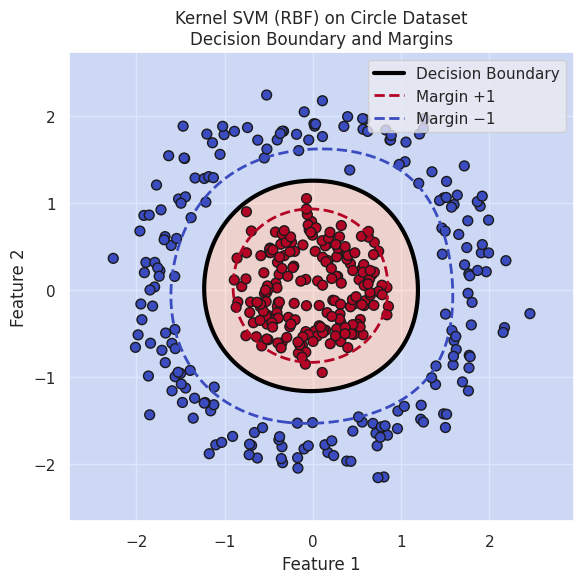

In [32]:
# -----------------------------
# Train RBF SVM
# -----------------------------
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_scaled, y)

xx, yy = create_meshgrid(X_scaled)
Z_rbf = svm_rbf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z_rbf>0, alpha=0.3, cmap='coolwarm')
plt.contour(xx, yy, Z_rbf, levels=[-1,0,1],
            colors=['#3b4cc0','black','#b40426'],
            linestyles=['--','-','--'],
            linewidths=[2,3,2])
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='coolwarm', edgecolors='k', s=50)

legend_lines = [
    Line2D([0],[0], color='black', lw=3, label='Decision Boundary'),
    Line2D([0],[0], color='#b40426', lw=2, linestyle='--', label='Margin +1'),
    Line2D([0],[0], color='#3b4cc0', lw=2, linestyle='--', label='Margin −1')
]
plt.legend(handles=legend_lines, loc='upper right')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Kernel SVM (RBF) on Circle Dataset\nDecision Boundary and Margins")
plt.tight_layout()
plt.show()
